In [2]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from typing import List, Set, Tuple, Dict
from river import feature_selection, stream, preprocessing
from tqdm.notebook import tqdm
from enum import Enum, auto

from sklearn.metrics import silhouette_score

import re
import os
import sys
sys.path.append('../')
from vibrodiagnostics import selection, models


PATH_PREFIX = '../../datasets/'
FEATURES_PATH =  os.path.join(PATH_PREFIX, 'features_data')

TD_FD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_AND_FREQ_FEATURES_PATH)
TD_FEATURES = os.path.join(FEATURES_PATH, selection.TIME_FEATURES_PATH)
FD_FEATURES = os.path.join(FEATURES_PATH, selection.FREQ_FEATURES_PATH)

# METRICS_TITLES = ('Correlation', 'F statistic', 'Mutual information')

In [3]:
faults = {
    'A': {
        'normal': 'normal',
        'imbalance': 'imbalance',
        'horizontal-misalignment': 'misalignment',
        'vertical-misalignment': 'misalignment',
        'underhang-outer_race': 'outer race fault',
        'underhang-cage_fault': 'cage fault',
        'underhang-ball_fault': 'ball fault'
    },
    'B': {
        'normal': 'normal',
        'imbalance': 'imbalance',
        'horizontal-misalignment': 'misalignment',
        'vertical-misalignment': 'misalignment',
        'overhang-cage_fault': 'cage fault',
        'overhang-ball_fault': 'ball fault',
        'overhang-outer_race': 'outer race fault'
    }
}

placements = {
    'A': ['ax', 'ay', 'az'],
    'B': ['bx', 'by', 'bz']
}


domains = {'temporal': TD_FEATURES, 'spectral': FD_FEATURES}
rpm_limit = [False, True]
target = ['fault', 'anomaly_60', 'anomaly_90']
placement = ['A', 'B']
online = [False, True]
GENERATE = False


class ExperimentOutput(Enum):
    COUNTS = auto()
    BEST_SET = auto()
    RANKS = auto()
    SCORES_RANGE = auto()
    PCA = auto()
    SILHOUETTE = auto()
    BEST_CORR = auto()
    BEST_F_STAT = auto()
    BEST_MI = auto()


def get_features_list(domains):
    features = []
    for dname, dataset in domains.items():
        names = pd.read_csv(dataset)
        names = names.columns.str.extract(r'([a-z]{2})_([a-z\_\-]+)')[1].unique()
        features.extend([f'{dname}_{col.strip("_")}' for col in names if not pd.isnull(col)])

    return features


temporal_columns = get_features_list({'temporal': TD_FEATURES})
spectral_columns = get_features_list({'spectral': FD_FEATURES})
all_columns = temporal_columns + spectral_columns

In [3]:
def silhouette_scores(X_train, X_test, Y_train, Y_test, best_features, pc):
    Y_train = Y_train.reset_index(drop=True).astype('category')
    Y_test = Y_test.reset_index(drop=True).astype('category')

    scaler = MinMaxScaler()
    X_train[X_train.columns] = scaler.fit_transform(X_train)
    X_test[X_test.columns] = scaler.transform(X_test)    

    model = PCA(n_components=pc).fit(X_train)
    X_train_pca = pd.DataFrame(model.transform(X_train))
    X_test_pca = pd.DataFrame(model.transform(X_test))

    return {
        'train': silhouette_score(X_train[best_features], Y_train),
        'test': silhouette_score(X_test[best_features], Y_test),
        'train_pca': silhouette_score(X_train_pca, Y_train),
        'test_pca': silhouette_score(X_test_pca, Y_test)
    }


def pca_explained_variances(X_train: pd.DataFrame, pc: int) -> Dict[str, float]:
    scaler = MinMaxScaler()
    X_train[X_train.columns] = scaler.fit_transform(X_train)
    model = PCA(n_components=pc).fit(X_train)    
    return {f'PC{pc}': var for pc, var in enumerate(model.explained_variance_ratio_, start=1)}


def batch_feature_ranking(X: pd.DataFrame, Y: pd.DataFrame, mode: str = 'rank') -> pd.DataFrame:
    metric_ranks = pd.DataFrame()
    METRICS_OFFLINE = {
        'corr': selection.corr_classif, 
        'f_stat': f_classif,
        'mi': mutual_info_classif
    }

    if mode in METRICS_OFFLINE:
        metric = METRICS_OFFLINE[mode]
        scores = metric(X, Y)
        if isinstance(scores, tuple):
            scores = scores[0]
        leaderboard = (
            pd.DataFrame(zip(X.columns, scores), columns=['feature', 'rank'])
            .set_index('feature')
            .sort_values(by='rank', ascending=False)
        )
        return leaderboard

    elif mode == 'rank':
        for metric_name, metric in METRICS_OFFLINE.items():
            scores = metric(X, Y)
            if isinstance(scores, tuple):
                scores = scores[0]
            leaderboard = (
                pd.DataFrame(zip(X.columns, scores), columns=['feature', 'score'])
                .set_index('feature')
                .sort_values(by='score', ascending=False)
            )
            metric_ranks[metric_name] = leaderboard
        
        ranks = metric_ranks.rank(axis='rows', method='first', ascending=False)
        return ranks.apply(gmean, axis=1).sort_values().to_frame(name='rank')
    

def online_feature_ranking(X: pd.DataFrame, Y: pd.Series, mode: str = 'rank') -> pd.DataFrame:
    METRICS_ONLINE = {
        'corr': selection.Correlation, 
        'f_stat': selection.FisherScore,
        'mi': selection.MutualInformation
    }

    if mode in METRICS_ONLINE:
        metric = METRICS_ONLINE[mode]
        estimator = feature_selection.SelectKBest(similarity=metric(), k=2)
        for xs, ys in stream.iter_pandas(X, Y):
            estimator.learn_one(xs, ys)

        best = [dict(estimator.leaderboard.copy())]
        features = pd.DataFrame.from_records(best)

    elif mode == 'rank':
        estimators = [
            feature_selection.SelectKBest(similarity=metric(), k=2)
            for metric in METRICS_ONLINE.values()
        ]

        best = []
        for xs, ys in stream.iter_pandas(X, Y):
            for method in estimators:
                method.learn_one(xs, ys)

            scores = [method.leaderboard.copy() for method in estimators]
            scores = pd.DataFrame.from_records(scores).T
            ranks = scores.rank(axis='rows', method='first', ascending=False)
            ranks = ranks.apply(gmean, axis=1).to_dict()   # Smallest rank is the best
            best.append(ranks)   

        features = pd.DataFrame.from_records(best)

    return (
        features.tail(1)
        .reset_index(drop=True)
        .T.rename(columns={0: 'rank'})
        .reset_index()
        .rename(columns={'index': 'feature'})
        .set_index('feature')
        .sort_values(by='rank', ascending=True)
    )


def compute_correlations(X: pd.DataFrame, corr_above: float) -> Set[Tuple[str, str]]:
    corr = [
        {'feature_1': k[0], 'feature_2': k[1], 'corr': v}
        for k, v in X.corr().abs().stack().to_dict().items()
        if k[0] != k[1]
    ]
    corr = pd.DataFrame.from_records(corr)

    # Remove correlated features independent of tuple order
    correlations = corr[corr['corr'] >= corr_above][
        ['feature_1', 'feature_2']
    ].to_numpy()
    similar_pairs = set([(a, b) for a, b in correlations])
    similar_pairs.update([(b, a) for a, b in correlations])
    return  similar_pairs


def best_columns(ranks: pd.DataFrame, corr: Set[Tuple[str, str]], n: int) -> List[str]:
    columns = []
    for feature in ranks.index:
        # Make pairs with existing columns
        candidates = [
            col for col in columns 
            if (feature, col) in corr
        ]        
        # Append only if not correlation detected
        if len(candidates) == 0:
            columns.append(feature)

    # Limit to n features
    columns = columns[:n]
    return columns


def best_subset(ranks: pd.DataFrame, corr: Set[Tuple[str, str]], n: int) -> pd.DataFrame:
    columns = best_columns(ranks, corr, n)
    subset = ranks.copy()
    subset['rank'] = False
    subset[subset.index.isin(tuple(columns))] = True
    return subset


def load_source(dataset: str, domain: str, row: dict, all: bool = False, window_size=2**14):
    RPM = 2500
    RPM_RANGE = 500
    features = pd.read_csv(dataset).fillna(0)

    if not all:
        # Choosing rpm range
        if row['rpm_limit']:
            features = features[features['rpm'].between(RPM - RPM_RANGE, RPM + RPM_RANGE, inclusive='both')]

        # Labeling anomaly severity levels
        target = re.search(r'([a-z]+)_?(\d+)?', row['target'])
        anomaly_severity = target.group(2) or '60'
        anomaly_severity = float(anomaly_severity) / 100

        # Choose measurement placement: A or B
        place = row['placement']
        axis = placements[place]
        features = features[features['fault'].isin(tuple(faults[place]))]
        features = models.fault_labeling(features, faults[place], anomaly_severity)

        columns = features.columns.str.startswith(tuple(axis))
        X = features[features.columns[columns]]

        # Select predicted variable column
        label = target.group(1)
        Y = features[label].astype('category')
    else:
        axis = placements['A']
        columns = features.columns.str.startswith(tuple(axis))
        X = features[features.columns[columns]]
        Y = features['fault'].astype('category')


    # Filter columns in feature domain with window size 2**14
    if domain == 'spectral':
        X = X.loc[:,X.columns.str.endswith(f'_{window_size}')]
        X.columns = X.columns.str.extract(r'(\w+)_\w+$')[0]

    # Calculate feature magnitudes from 3D vector
    feature_names = get_features_list({domain: dataset})
    result = pd.DataFrame()
    for name in feature_names:              
        # Remove prefix: temporal, spectral
        name = re.search(r'[a-z]+_([\w\_]+)', name).group(1)
        vector_dims = [f'{dim}_{name}' for dim in axis]
        result[name] = X[vector_dims].apply(np.linalg.norm, axis=1)
    X = result

    # Batch / Online hold-out (balance and event sequencing)
    train_size = 0.8
    if row['online']:
        # Shuffle order within severity level and order event with increasing severity
        groups = [
            df.sample(frac=1, random_state=10)
            for i, df in (
                features.sort_values(by='severity_level').groupby('severity_level')
            )
        ]
        rows = list(pd.concat(groups).index)
        X = X.loc[rows].reset_index(drop=True)
        Y = Y.loc[rows].reset_index(drop=True)

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, train_size=train_size, random_state=10
        )   
        X_train, X_test, Y_train, Y_test = (
            X_train.sort_index(), X_test.sort_index(),
            Y_train.sort_index(), Y_test.sort_index()
        )

    else:
        oversample = RandomOverSampler(sampling_strategy='not majority', random_state=10)
        X, Y = oversample.fit_resample(X, Y.to_numpy())
        X.reset_index(drop=True, inplace=True)
        Y = pd.Series(Y)

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, train_size=train_size, stratify=Y, random_state=10
        )

    return X_train, X_test, Y_train, Y_test


def run_experiments(conditions: List[dict], exp_output: ExperimentOutput, pc=3) -> pd.DataFrame:
    experiments = []

    for row in tqdm(conditions):
        experiment = row.copy()

        for domain_label, dataset in domains.items():
            X_train, X_test, Y_train, Y_test = load_source(dataset, domain_label, row)

            # Count samples
            if exp_output == ExperimentOutput.COUNTS:
                experiment.update({'n_train': len(X_train), 'n_test': len(X_test), 'sum': len(X)})
                break

            elif exp_output == ExperimentOutput.PCA:
                experiment = row.copy()
                experiment.update({'domain': domain_label})
                experiment.update(pca_explained_variances(X_train, pc))
                experiments.append(experiment)
                continue

            elif exp_output == ExperimentOutput.SILHOUETTE:
                synonyms = compute_correlations(X_train, corr_above=0.95)
                if row['online']:
                    ranks = online_feature_ranking(X_train, Y_train)
                else:
                    ranks = batch_feature_ranking(X_train, Y_train)
    
                best_features = best_columns(ranks, synonyms, n=3)
                scores = silhouette_scores(X_train, X_test, Y_train, Y_test, best_features, pc)
                experiment = row.copy()
                experiment.update({'domain': domain_label})
                experiment.update(scores)
                experiments.append(experiment)
                continue

            elif exp_output == ExperimentOutput.BEST_SET:
                if row['online']:
                    ranks = online_feature_ranking(X_train, Y_train)
                else:
                    ranks = batch_feature_ranking(X_train, Y_train)
                synonyms = compute_correlations(X_train, corr_above=0.95)
                subset = best_subset(ranks, synonyms, n=3)
                output = subset

            elif exp_output == ExperimentOutput.BEST_CORR:
                if row['online']:
                    ranks = online_feature_ranking(X_train, Y_train, 'corr')
                else:
                    ranks = batch_feature_ranking(X_train, Y_train, 'corr')
                synonyms = compute_correlations(X_train, corr_above=0.95)
                subset = best_subset(ranks, synonyms, n=3)
                output = subset

            elif exp_output == ExperimentOutput.BEST_F_STAT:
                if row['online']:
                    ranks = online_feature_ranking(X_train, Y_train, 'f_stat')
                else:
                    ranks = batch_feature_ranking(X_train, Y_train,'f_stat')
                synonyms = compute_correlations(X_train, corr_above=0.95)
                subset = best_subset(ranks, synonyms, n=3)
                output = subset

            elif exp_output == ExperimentOutput.BEST_MI:
                if row['online']:
                    ranks = online_feature_ranking(X_train, Y_train, 'mi')
                else:
                    ranks = batch_feature_ranking(X_train, Y_train, 'mi')
                synonyms = compute_correlations(X_train, corr_above=0.95)
                subset = best_subset(ranks, synonyms, n=3)
                output = subset
    
            elif exp_output == ExperimentOutput.RANKS:
                if row['online']:
                    ranks = online_feature_ranking(X_train, Y_train)
                else:
                    ranks = batch_feature_ranking(X_train, Y_train)
                output = ranks

            output.reset_index(inplace=True)
            output['feature'] = output['feature'].apply(lambda s: f'{domain_label}_{s}')
            output = dict(zip(list(output['feature']), list(output['rank'])))
            experiment.update(output)

        if exp_output not in (ExperimentOutput.PCA, ExperimentOutput.SILHOUETTE):
            experiments.append(experiment)

    return pd.DataFrame.from_records(experiments)

In [4]:
column_names = ['rpm_limit', 'target', 'placement', 'online']
initial_conditions = [
    dict(zip(column_names, row)) 
    for row in itertools.product(rpm_limit, target, placement, online)
]

#### Majority voting: feature in subsets

#### 3 member sets

In [ ]:
if GENERATE:
    membership = run_experiments(initial_conditions, ExperimentOutput.BEST_SET)
    membership.to_csv('best_set/rank_product.csv', index=False)
    membership = run_experiments(initial_conditions, ExperimentOutput.BEST_CORR)
    membership.to_csv('best_set/corr.csv', index=False)
    membership = run_experiments(initial_conditions, ExperimentOutput.BEST_F_STAT)
    membership.to_csv('best_set/fstat.csv', index=False)
    membership = run_experiments(initial_conditions, ExperimentOutput.BEST_MI)
    membership.to_csv('best_set/mi.csv', index=False)

In [ ]:
# Globally best features (batch and online)
def globally_best_batch_features(filename):
    best_set_membership = pd.read_csv(filename)

    group = best_set_membership[(best_set_membership['online'] == False) & (best_set_membership['target'] == 'fault')]
    for i, col in enumerate([temporal_columns, spectral_columns]):
        graph = group[col][group == True].count(axis=0).sort_values(ascending=False)
        #print(graph)
        plt.grid()
        plt.bar([re.search('[a-z]+_(\w+)', s).group(1) for s in graph.index], graph)
        plt.show()

    # Online
    # group = best_set_membership[best_set_membership['online'] == True]
    # for i, col in enumerate([temporal_columns, spectral_columns]):
    #     graph = group[col][group == True].count(axis=0).sort_values(ascending=False)
    #     #print(graph)
    #     plt.grid()
    #     plt.bar([re.search('[a-z]+_(\w+)', s).group(1) for s in graph.index], graph)
    #     plt.show()

In [ ]:
globally_best_batch_features('best_set/rank_product.csv')

In [ ]:
globally_best_batch_features('best_set/corr.csv')

In [ ]:
globally_best_batch_features('best_set/fstat.csv')

In [ ]:
globally_best_batch_features('best_set/mi.csv')

In [ ]:
best_set_membership = pd.read_csv('best_set/rank_product.csv')
agg = pd.DataFrame()
for key, group in best_set_membership.groupby(by=['rpm_limit', 'online']):
    t_situation = group[temporal_columns][group == True].count(axis=0).sort_values(ascending=False).head(3)
    f_situation = group[spectral_columns][group == True].count(axis=0).sort_values(ascending=False).head(3)
    agg[key] = pd.concat([t_situation, f_situation]).index
agg

In [ ]:
best_set_membership = pd.read_csv('best_set/rank_product.csv')
agg = pd.DataFrame()
for key, group in best_set_membership.groupby(by=['rpm_limit', 'online', 'target']):
    t_situation = group[temporal_columns][group == True].count(axis=0).sort_values(ascending=False).head(3)
    f_situation = group[spectral_columns][group == True].count(axis=0).sort_values(ascending=False).head(3)
    agg[key] = pd.concat([t_situation, f_situation]).index
agg

#### Rank product: feature ordering

In [ ]:
if GENERATE:
    best_set_ranks = run_experiments(initial_conditions, ExperimentOutput.RANKS)    # 6 minutes
    best_set_ranks.to_csv('best_set_ranks.csv', index=False)
    best_set_ranks.head()

In [ ]:
best_set_ranks = pd.read_csv('best_set_ranks.csv')
# Globally best features (lower rank is better)

group = best_set_ranks[best_set_ranks['online'] == False]
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for i, col in enumerate([temporal_columns, spectral_columns]):
    graph = group[col].apply(gmean, axis=0).sort_values(ascending=True)
    print(graph)
    ax[i].grid()
    ax[i].bar([re.search('[a-z]+_(\w+)', s).group(1) for s in graph.index], graph)
plt.show()

# Online
group = best_set_ranks[best_set_ranks['online'] == True]
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for i, col in enumerate([temporal_columns, spectral_columns]):
    graph = group[col].apply(gmean, axis=0).sort_values(ascending=True)
    print(graph)
    ax[i].grid()
    ax[i].bar([re.search('[a-z]+_(\w+)', s).group(1) for s in graph.index], graph)
plt.show()

In [ ]:
# Summary (absolute counts) - RPM limited/unlimted and machinery element
best_set_ranks = pd.read_csv('best_set_ranks.csv')
agg = pd.DataFrame()
for key, group in best_set_ranks.groupby(by=['rpm_limit', 'online']):
    agg[key] = group[all_columns].apply(gmean, axis=0)
agg

In [ ]:
best_set_ranks = pd.read_csv('best_set_ranks.csv')
agg = pd.DataFrame()
for key, group in best_set_ranks.groupby(by=['rpm_limit', 'online']):
    t_situation = group[temporal_columns].apply(gmean, axis=0).sort_values(ascending=True).head(3)
    f_situation = group[spectral_columns].apply(gmean, axis=0).sort_values(ascending=True).head(3)
    agg[key] = pd.concat([t_situation, f_situation]).index
agg

In [ ]:
# Summary (absolute counts) - RPM limited/unlimted and machinery element
best_set_ranks = pd.read_csv('best_set_ranks.csv')
agg = pd.DataFrame()
for key, group in best_set_ranks.groupby(by=['rpm_limit', 'online', 'target']):
    agg[key] = group[all_columns].apply(gmean, axis=0)
agg

In [ ]:
best_set_ranks = pd.read_csv('best_set_ranks.csv')
agg = pd.DataFrame()
for key, group in best_set_ranks.groupby(by=['rpm_limit', 'online', 'target']):
    t_situation = group[temporal_columns].apply(gmean, axis=0).sort_values(ascending=False).head(3)
    f_situation = group[spectral_columns].apply(gmean, axis=0).sort_values(ascending=False).head(3)
    agg[key] = pd.concat([t_situation, f_situation]).index
agg

### Best features by experiment
- Majority voting
- Ranking

In [ ]:
def extract_feature_names(feature_set):
    return [re.search('[a-z]+_(\w+)', s).group(1) for s in feature_set.index]

def best_featue_set_methods(filename):
    best_set_membership = pd.read_csv(filename)
    feature_sets = []
    indexer = ['placement', 'online', 'rpm_limit', 'target']
    for key, group in best_set_membership.groupby(by=indexer):
        t_situation = group[temporal_columns][group == True].count(axis=0).sort_values(ascending=False).head(3)
        f_situation = group[spectral_columns][group == True].count(axis=0).sort_values(ascending=False).head(3)

        # Extract feature names
        temporal = list(sorted(extract_feature_names(t_situation)))
        spectral = list(sorted(extract_feature_names(f_situation)))

        fset = {'placement': key[0], 'online': key[1], 'rpm_limit': key[2], 'target': key[3], 'temporal': temporal , 'spectral': spectral}
        feature_sets.append(fset)

    return pd.DataFrame.from_records(feature_sets).set_index(indexer)

In [ ]:
best_featue_set_methods('best_set/rank_product.csv')

In [ ]:
best_featue_set_methods('best_set/corr.csv')

In [ ]:
best_featue_set_methods('best_set/fstat.csv')

In [ ]:
best_featue_set_methods('best_set/mi.csv')

In [ ]:
def extract_feature_names(feature_set):
    return [re.search('[a-z]+_(\w+)', s).group(1) for s in feature_set.index]

best_set_membership = pd.read_csv('best_set_ranks.csv')
feature_sets = []
indexer = ['placement', 'online', 'rpm_limit', 'target']
for key, group in best_set_membership.groupby(by=indexer):
    t_situation = group[temporal_columns].apply(gmean, axis=0).sort_values(ascending=False).head(3)
    f_situation = group[spectral_columns].apply(gmean, axis=0).sort_values(ascending=False).head(3)

    # Extract feature names
    temporal = list(sorted(extract_feature_names(t_situation)))
    spectral = list(sorted(extract_feature_names(f_situation)))

    fset = {'placement': key[0], 'online': key[1], 'rpm_limit': key[2], 'target': key[3], 'temporal': temporal , 'spectral': spectral}
    feature_sets.append(fset)

pd.DataFrame.from_records(feature_sets).set_index(indexer)

#### PCA explained variance (batch only)

In [ ]:
column_names = ['rpm_limit', 'target', 'placement', 'online']
batch_initial_conditions = [
    dict(zip(column_names, row)) 
    for row in itertools.product(rpm_limit, target, placement, [False])
]
pca_vars = run_experiments(batch_initial_conditions, ExperimentOutput.PCA)
pca_vars

In [ ]:
def plot_explained_variances(pca_vars_in):
    selected_columns = ['target', 'PC1', 'PC2', 'PC3']
    groupby_columns = ['target']

    pca_A_temporal = pca_vars_in[
        (pca_vars_in['placement'] == 'A') & (pca_vars_in['domain'] == 'temporal')
    ][selected_columns].set_index(groupby_columns)
    pca_B_temporal = pca_vars_in[
        (pca_vars_in['placement'] == 'B') & (pca_vars_in['domain'] == 'temporal')
    ][selected_columns].set_index(groupby_columns)

    pca_A_spectral = pca_vars_in[
        (pca_vars_in['placement'] == 'A') & (pca_vars_in['domain'] == 'spectral')
    ][selected_columns].set_index(groupby_columns)
    pca_B_spectral = pca_vars_in[
        (pca_vars_in['placement'] == 'B') & (pca_vars_in['domain'] == 'spectral')
    ][selected_columns].set_index(groupby_columns)

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    pca_A_temporal.plot.bar(stacked=True, grid=True, ax=ax[0][0], title='Temporal features, Placement: A', xlabel='', ylabel='Explained variance')
    pca_B_temporal.plot.bar(stacked=True, grid=True, ax=ax[0][1], title='Temporal features, Placement: B', xlabel='', ylabel='Explained variance')
    pca_A_spectral.plot.bar(stacked=True, grid=True, ax=ax[1][0], title='Spectral features, Placement: A', xlabel='', ylabel='Explained variance')
    pca_B_spectral.plot.bar(stacked=True, grid=True, ax=ax[1][1], title='Spectral features, Placement: B', xlabel='', ylabel='Explained variance')
    plt.tight_layout()
    plt.show()

# No RPM limit
plot_explained_variances(pca_vars[pca_vars['rpm_limit'] == False])

In [ ]:
# RPM limited
plot_explained_variances(pca_vars[pca_vars['rpm_limit'] == True])

#### Baseline for number of features: Principal components explanation power

In [ ]:
# column_names = ['rpm_limit', 'target', 'placement', 'online']
# batch_initial_conditions = [
#     dict(zip(column_names, row)) 
#     for row in itertools.product(rpm_limit, target, placement, [False])
# ]

# pca_components_power = []
# for pc in range(1, 5):
#     e_pc = (
#         run_experiments(batch_initial_conditions, ExperimentOutput.PCA, pc=pc)
#         .drop(columns=['online'])
#         .set_index(['rpm_limit', 'target', 'placement', 'domain'])
#     )
#     e_silh = (
#         run_experiments(batch_initial_conditions, ExperimentOutput.SILHOUETTE, pc=pc)
#         .drop(columns=['online'])
#         .set_index(['rpm_limit', 'target', 'placement', 'domain'])
#     )
#     e = e_pc.join(e_silh)
#     e['n_pc'] = pc
#     pca_components_power.append(e)

In [ ]:
pca_power = pd.concat(pca_components_power).fillna(0).reset_index()
pca_power = pca_power[(pca_power['rpm_limit'] == False) & (pca_power['target'].str.startswith('fault'))]
pca_power = pca_power[['n_pc'] + list(pca_power.columns[pca_power.columns.str.startswith('PC')])]
pca_power.groupby(by='n_pc').mean()

In [ ]:
pca_power = pd.concat(pca_components_power).fillna(0).reset_index()
pca_power = pca_power[(pca_power['rpm_limit'] == False) & (pca_power['target'].str.startswith('anomaly'))]
pca_power = pca_power[['n_pc'] + list(pca_power.columns[pca_power.columns.str.startswith('PC')])]
pca_power.groupby(by='n_pc').mean()

In [ ]:
pca_power = pd.concat(pca_components_power).fillna(0).reset_index()
pca_power = pca_power[(pca_power['rpm_limit'] == False)  & (pca_power['target'].str.startswith('fault'))]
pca_power = pca_power[['n_pc'] + list(pca_power.columns[pca_power.columns.str.startswith('PC')])]
pca_power.groupby(by='n_pc').mean()

In [ ]:
pca_power = pd.concat(pca_components_power).fillna(0).reset_index()
pca_power = pca_power[(pca_power['rpm_limit'] == False) & (pca_power['target'].str.startswith('anomaly'))]
pca_power = pca_power[['n_pc'] + list(pca_power.columns[pca_power.columns.str.startswith('PC')])]
pca_power.groupby(by='n_pc').mean()

In [ ]:
pca_power = pd.concat(pca_components_power).fillna(0).reset_index()
pca_power = pca_power[(pca_power['rpm_limit'] == False) & (pca_power['target'].str.startswith('anomaly'))]
pca_power = pca_power[['n_pc'] + list(pca_power.columns[pca_power.columns.str.endswith('_pca')])]
pca_power.groupby(by='n_pc').mean()

#### Silhouette scores

In [ ]:
scores = run_experiments(batch_initial_conditions, ExperimentOutput.SILHOUETTE)
scores

In [ ]:
def plot_silhouette_scores(scores, cols):
    selected_columns = ['target'] + cols
    groupby_columns = ['target']

    scores_A_temporal = scores[
        (scores['placement'] == 'A') & (scores['domain'] == 'temporal')
    ][selected_columns].set_index(groupby_columns)
    scores_B_temporal = scores[
        (scores['placement'] == 'B') & (scores['domain'] == 'temporal')
    ][selected_columns].set_index(groupby_columns)

    scores_A_spectral = scores[
        (scores['placement'] == 'A') & (scores['domain'] == 'spectral')
    ][selected_columns].set_index(groupby_columns)
    scores_B_spectral = scores[
        (scores['placement'] == 'B') & (scores['domain'] == 'spectral')
    ][selected_columns].set_index(groupby_columns)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    scores_A_temporal.plot.bar(grid=True, ax=ax[0][0], title='Temporal features, Placement: A', xlabel='', ylabel='Silhouette score')
    scores_B_temporal.plot.bar(grid=True, ax=ax[0][1], title='Temporal features, Placement: B', xlabel='', ylabel='Silhouette variance')
    scores_A_spectral.plot.bar(grid=True, ax=ax[1][0], title='Spectral features, Placement: A', xlabel='', ylabel='Silhouette variance')
    scores_B_spectral.plot.bar(grid=True, ax=ax[1][1], title='Spectral features, Placement: B', xlabel='', ylabel='Silhouette variance')
    plt.tight_layout()

plot_silhouette_scores(scores[scores['rpm_limit'] == False], ['train', 'test'])
#plt.suptitle('Best features, all RPM')
plt.show()

In [ ]:
plot_silhouette_scores(scores[scores['rpm_limit'] == False], ['train_pca', 'test_pca'])
plt.suptitle('PCA, all RPM')
plt.show()

#### Dataset sizes

In [ ]:
counters = run_experiments(initial_conditions, ExperimentOutput.COUNTS)  
counters.head()

In [ ]:
samples = (counters[['rpm_limit', 'online', 'target', 'n_train', 'n_test', 'sum']]
.groupby(by=['rpm_limit', 'online', 'target'])
.first())
samples

In [ ]:
samples.loc[:, samples.columns != 'sum'].plot.bar(stacked=True, grid=True)
plt.show()

Feature distribution in diffrent classes

In [ ]:
def boxplot_features(conditions: List[dict]):
    for row in tqdm(conditions):
        experiment = row.copy()
        print(row)

        for domain_label, dataset in domains.items():
            X_train, X_test, Y_train, Y_test = load_source(dataset, domain_label, row)

            # MinMax scaled result
            # scaler = MinMaxScaler()
            # X_train_scaled = pd.DataFrame()
            # X_train_scaled[X_train.columns] = scaler.fit_transform(X_train)
            X_train_scaled = X_train

            # Diagonal of covariance matrix to see explained variance cov(A, A) = var(A)
            # Variance threshold
            train_cov = X_train_scaled.cov()
            diagonal_cov = pd.Series(np.diag(train_cov), index=[train_cov.index, train_cov.columns])
            diagonal_cov = diagonal_cov / diagonal_cov.sum()
            diagonal_cov = diagonal_cov.sort_values(ascending=False)
            print(row)
            print(diagonal_cov)

            X_train_scaled['target'] = Y_train
            # Show boxplots split by predicted variable
            X_train_scaled.boxplot(figsize=(15, 5))
            plt.show()
            X_train_scaled.boxplot(figsize=(20, 5), layout=(2, 6), by='target', sharey=False)
            plt.show()

column_names = ['rpm_limit', 'target', 'placement', 'online']
batch_initial_conditions = [
    dict(zip(column_names, row)) 
    for row in itertools.product(rpm_limit, target, placement, [False])
]
boxplot_features(batch_initial_conditions)

In [5]:
def load_whole_dataset(dataset: str, domain: str, window_size=2**14):
    features = pd.read_csv(dataset).fillna(0)

    axis = placements['A']
    columns = features.columns.str.startswith(tuple(axis))
    X = features[features.columns[columns]]
    Y = features['rpm'].astype('category')

    # Filter columns in feature domain with window size 2**14
    if domain == 'spectral':
        X = X.loc[:,X.columns.str.endswith(f'_{window_size}')]
        X.columns = X.columns.str.extract(r'(\w+)_\w+$')[0]

    # Calculate feature magnitudes from 3D vector
    feature_names = get_features_list({domain: dataset})
    result = pd.DataFrame()
    for name in feature_names:              
        # Remove prefix: temporal, spectral
        name = re.search(r'[a-z]+_([\w\_]+)', name).group(1)
        vector_dims = [f'{dim}_{name}' for dim in axis]
        result[name] = X[vector_dims].apply(np.linalg.norm, axis=1)
    X = result

    return X, Y

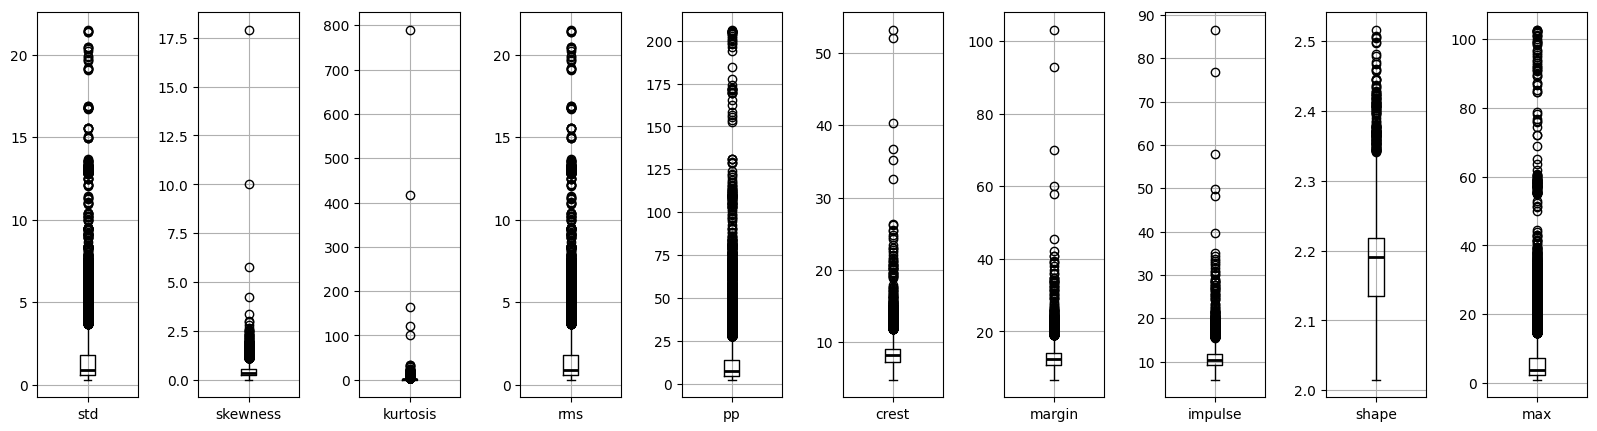

[6.76125979e-01 2.67084199e-01 4.37230883e-02 7.77501913e-03
 3.76955098e-03 9.27557463e-04 5.33859689e-04 6.02288400e-05
 5.17784667e-07 1.70776910e-19]
[0.67612598 0.94321018 0.98693327 0.99470829 0.99847784 0.99940539
 0.99993925 0.99999948 1.         1.        ]


,0
shape,28.884921
rms,16.830157
std,16.830157
max,14.787639
pp,14.556440
crest,2.835795
margin,2.188453
impulse,2.053745
skewness,0.795988
kurtosis,0.236707


In [6]:
boxprops = dict(linewidth=1, color='k')
medianprops = dict(linewidth=2, color='k')
X, Y = load_whole_dataset(TD_FEATURES, 'temporal')
X.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(20, 5),
    grid=True,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=boxprops,
    capprops=boxprops
    
)

corrs = {}
for col in X.columns:
    corrs[col] = np.corrcoef(X[col], Y)[0, 1]

plt.subplots_adjust(wspace=0.6) 
#plt.tight_layout()
plt.show()
#pd.DataFrame.from_records([corrs]).T.describe()

x_scaled = pd.DataFrame()
x_scaled[X.columns] = MinMaxScaler().fit_transform(X)
vars = {}

X_td = X.copy()
pca_td = PCA(n_components=10)
X_pca = pca_td.fit_transform(x_scaled)
print(pca_td.explained_variance_ratio_)
print(np.cumsum(pca_td.explained_variance_ratio_))

for col in x_scaled.columns:
    vars[col] = np.var(x_scaled[col])
vars = pd.DataFrame.from_records([vars]).T


(100 * (vars / vars.sum())).sort_values(by=0, ascending=False)

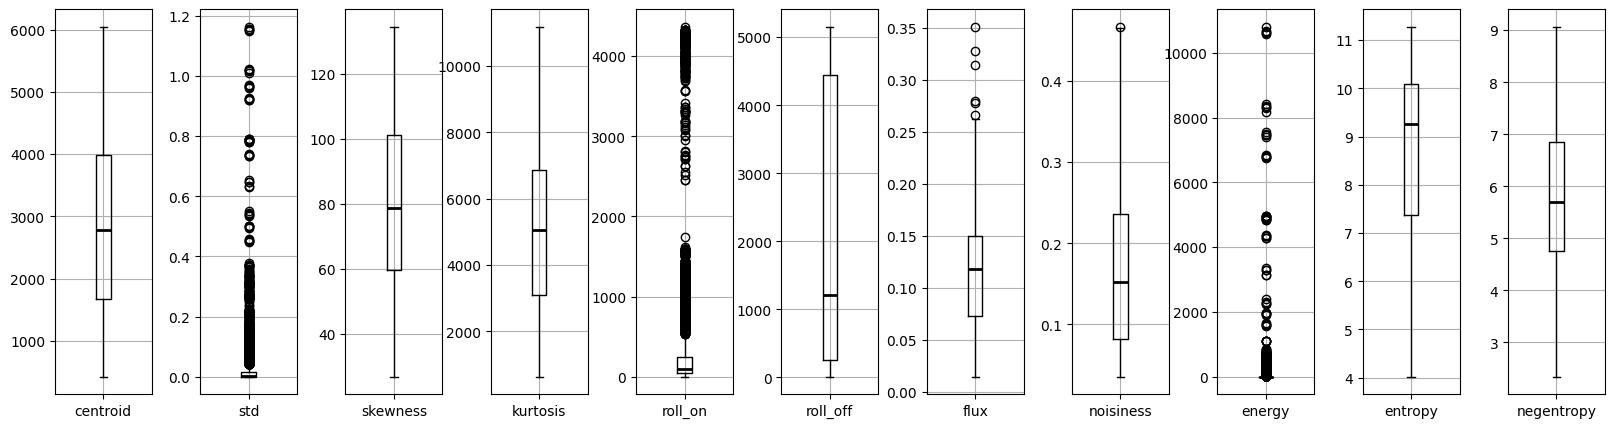

[7.85159956e-01 7.34552678e-02 5.19749616e-02 4.19768852e-02
 1.58973279e-02 1.05883609e-02 9.14130807e-03 6.56636010e-03
 4.13321456e-03 6.14766848e-04]
[0.78515996 0.85861522 0.91059019 0.95256707 0.9684644  0.97905276
 0.98819407 0.99476043 0.99889364 0.99950841]


,0
roll_off,27.830342
entropy,12.585407
skewness,11.369503
centroid,11.349976
kurtosis,11.319790
noisiness,9.001864
negentropy,6.844270
roll_on,4.671104
flux,3.901761
std,0.790807


In [7]:
WIN_SIZE = 2**14
X, Y = load_whole_dataset(FD_FEATURES, 'spectral', WIN_SIZE)
X.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(20, 5),
    grid=True,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=boxprops,
    capprops=boxprops
    
)
corrs = {}
for col in X.columns:
    corrs[col] = np.corrcoef(X[col], Y)[0, 1]

plt.subplots_adjust(wspace=0.5) 
plt.show()
#pd.DataFrame.from_records([corrs]).T.sort_values(by=0) #.describe()
#covs = pd.DataFrame([cov]).T



x_scaled = pd.DataFrame()
x_scaled[X.columns] = MinMaxScaler().fit_transform(X)
vars = {}

X_fd = X.copy()
pca_fd = PCA(n_components=10)
X_pca = pca_fd.fit_transform(x_scaled)
print(pca_fd.explained_variance_ratio_)
print(np.cumsum(pca_fd.explained_variance_ratio_))

for col in x_scaled.columns:
    vars[col] = np.var(x_scaled[col])
vars = pd.DataFrame.from_records([vars]).T

# Explained variances
(100 * (vars / vars.sum())).sort_values(by=0, ascending=False)

Explainde varinace by PCA components

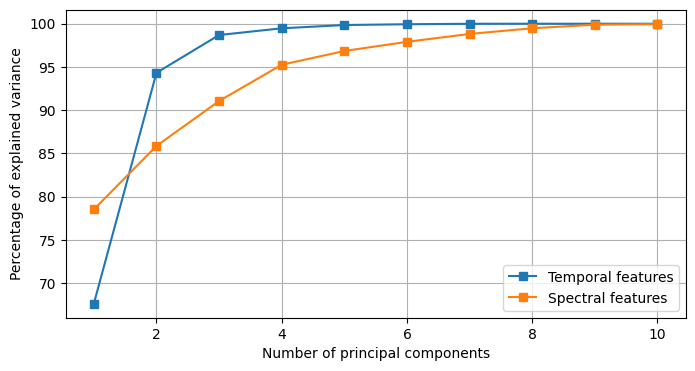

In [119]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, 11), 100 * np.cumsum(pca_td.explained_variance_ratio_), marker='s', label='Temporal features')
ax.plot(np.arange(1, 11), 100 * np.cumsum(pca_fd.explained_variance_ratio_), marker='s', label='Spectral features')
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Percentage of explained variance')
ax.grid()
ax.legend()
plt.show()

Loadings plot
- https://www.jcchouinard.com/python-pca-biplots-machine-learning/
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/multivariate/how-to/principal-components/interpret-the-results/key-results/

In [9]:
loadings = pca_td.components_
n_features = pca_td.n_features_in_
feature_names = X_td.columns
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))

# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df[['PC1', 'PC2']]


,PC1,PC2
feature_names,,
std,0.479450,-0.208834
skewness,0.053272,0.037339
kurtosis,0.003782,0.015626
rms,0.479450,-0.208834
pp,0.453979,-0.135914
crest,0.039594,0.204391
margin,0.046491,0.196211
impulse,0.040963,0.183709
shape,0.346954,0.870054


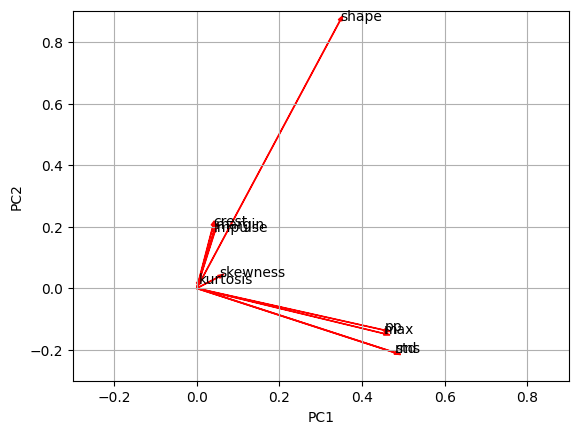

In [39]:
from adjustText import adjust_text

xs = loadings[0]
ys = loadings[1]

texts = []
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r', 
        head_width=0.01
    )
    texts.append(plt.text(xs[i], ys[i], varnames))

# Define the axes
adjust_text(texts, only_move={'points':'y', 'texts':'y'})
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-0.3, 0.9)
plt.ylim(-0.3, 0.9)
plt.grid()
fig.tight_layout()
plt.show()

In [25]:

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.text import Annotation



class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)
setattr(Axes3D, 'arrow3D', _arrow3D)

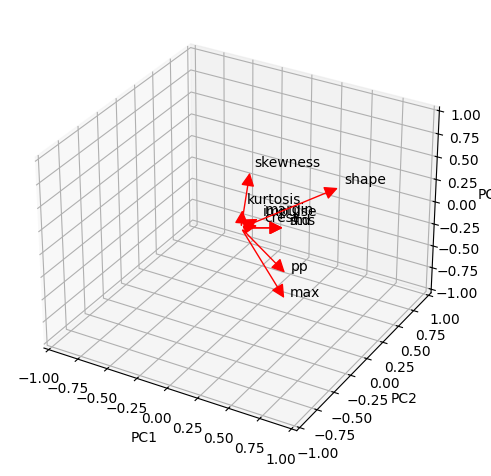

In [33]:
xs = loadings[0]
ys = loadings[1]
zs = loadings[3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    # plt.scatter(xs[i], ys[i], s=200)
    ax.arrow3D(
        0, 0, 0, # coordinates of arrow base
        xs[i], ys[i], zs[i],
        color='r', 
        mutation_scale=20,
        arrowstyle="-|>"
    )
    ax.annotate3D(varnames, (xs[i], ys[i], zs[i]), xytext=(3, 3), textcoords='offset points')

# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
fig.tight_layout()
plt.show()